# Fault Free Analog Computing

## Generate the simulation chip

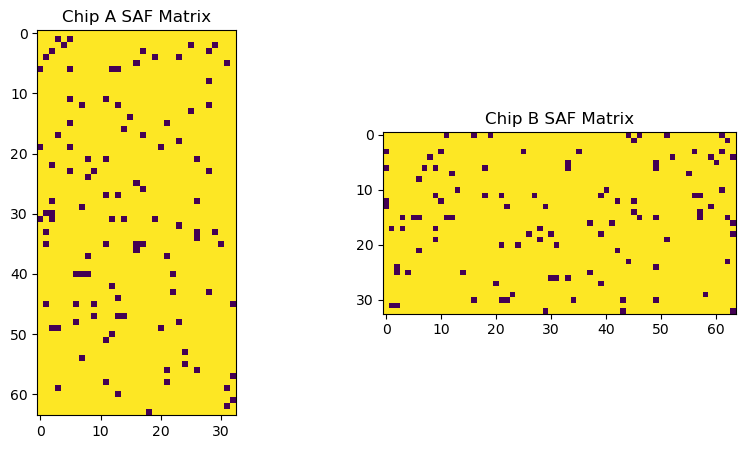

In [1]:
from SimChip import *
import matplotlib.pyplot as plt
# generate the simulation chip with 64x33 and 33x64
SA0_rate = 0.05
chipA0 = SimChip(64,33,SA0_rate)
chipB0 = SimChip(33,64,SA0_rate)
SAFinfo_A0 = chipA0.mask_matrix
SAFinfo_B0 = chipB0.mask_matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(SAFinfo_A0.T)
ax1.set_title('Chip A SAF Matrix')
ax2.imshow(SAFinfo_B0.T)
ax2.set_title('Chip B SAF Matrix')
plt.show()


# Select the Target Matrix

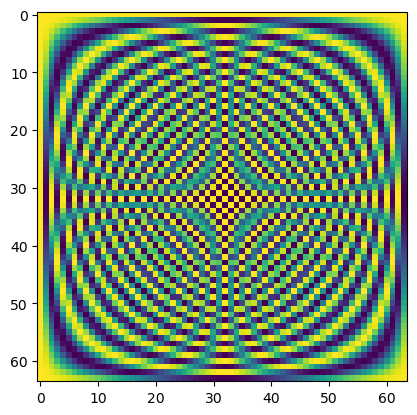

In [2]:
# Generate the real part of the 64-point DFT matrix (using a library)
dft_matrix = torch.fft.fft(torch.eye(64))
dft_matrix_real = torch.real(dft_matrix)
plt.imshow(dft_matrix_real)
plt.show()


# Using the model to optimize the submatrix

In [3]:
from FFAC import *
layer=[64,33,64]
first_layer_model=MapAlg(dft_matrix_real,SAFinfo_A0,SAFinfo_B0,layer=layer,device='cuda:0')

self.fc1 shape: torch.Size([33, 64])
self.fc2 shape: torch.Size([64, 33])


In [4]:
lr=1e-4
for i in range(20):
    epochs=1000
    print("epochs:",epochs*(i+1),"loss:",first_layer_model.fit_cos(epochs,lr,bestmode="off",resetflag=False,visual=False))


epochs: 1000 loss: 0.044008937912224155
epochs: 2000 loss: 0.00042620212458455153
epochs: 3000 loss: 3.658743358503358e-05
epochs: 4000 loss: 3.36930167654792e-06
epochs: 5000 loss: 8.054903967158467e-07
epochs: 6000 loss: 1.3591207476126854e-06
epochs: 7000 loss: 1.8143590518882036e-08
epochs: 8000 loss: 3.535506831742197e-08
epochs: 9000 loss: 2.2269719401890598e-10
epochs: 10000 loss: 1.1392664589493506e-11
epochs: 11000 loss: 5.6804116965736284e-11
epochs: 12000 loss: 1.2475798172317809e-11
epochs: 13000 loss: 1.7664950169304916e-08
epochs: 14000 loss: 8.897527159490437e-11
epochs: 15000 loss: 1.2534417948018017e-11
epochs: 16000 loss: 5.664291258256071e-11
epochs: 17000 loss: 2.4589219549397967e-11
epochs: 18000 loss: 5.949285508677349e-11
epochs: 19000 loss: 1.3010544517300104e-06
epochs: 20000 loss: 5.5138116294983774e-11


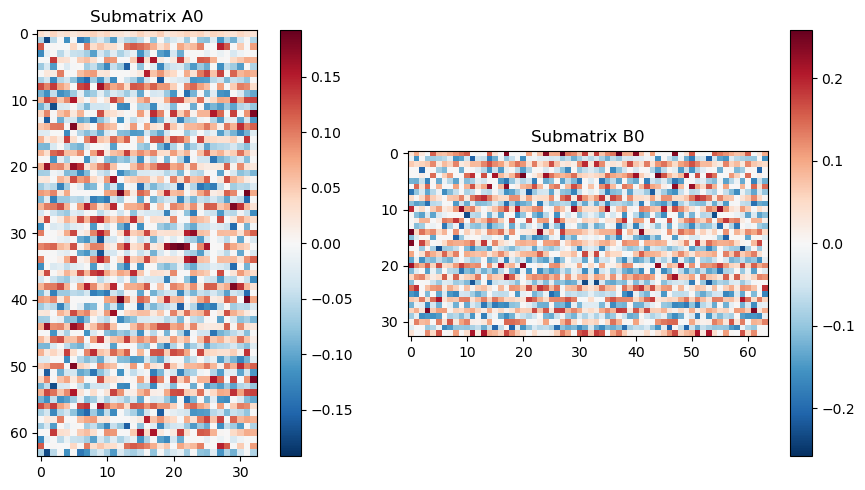

In [5]:
#

submatrixA0,submatrixB0=first_layer_model.weight_to_supert()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
cmap = plt.cm.RdBu_r  # 使用RdBu_r色图：红色为正值，蓝色为负值

# 显示子矩阵A
max_val_A = np.max(np.abs(submatrixA0.cpu().numpy()))
cax1 = ax1.imshow(submatrixA0.cpu().numpy().T, cmap=cmap, vmin=-max_val_A, vmax=max_val_A)
ax1.set_title('Submatrix A0')
fig.colorbar(cax1, ax=ax1)

# 显示子矩阵B
max_val_B = np.max(np.abs(submatrixB0.cpu().numpy()))
cax2 = ax2.imshow(submatrixB0.cpu().numpy().T, cmap=cmap, vmin=-max_val_B, vmax=max_val_B)
ax2.set_title('Submatrix B0')
fig.colorbar(cax2, ax=ax2)

plt.tight_layout()
plt.show()


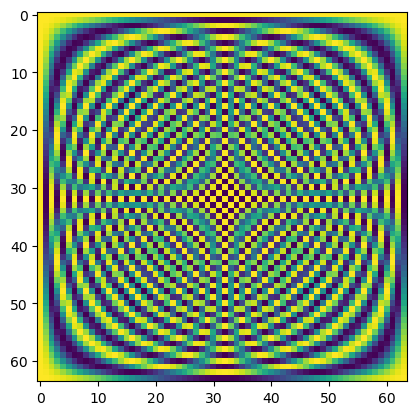

In [6]:
plt.imshow(np.dot(submatrixA0.cpu().numpy().T,submatrixB0.cpu().numpy().T))


# Simulation program the submatrix to the Simchip
* get_Target is used for the compensate layer (not the final layer)

In [7]:

chipA0.get_target_value(submatrixA0.cpu())
chipB0.get_target_value(submatrixB0.cpu())
# Simulate programming the submatrix to the Simchip
variation_rate = 0
chipA0.sim_program(variation_rate)
chipB0.sim_program(variation_rate)


tensor([[ 1.8857e-05, -1.0548e-05,  3.9762e-05,  ...,  4.6943e-06,
         -1.7939e-05,  2.1335e-05],
        [ 5.5092e-05, -9.1024e-05,  2.7773e-05,  ...,  7.5304e-05,
          0.0000e+00,  3.0797e-12],
        [ 1.5645e-05, -4.0353e-10,  3.3499e-05,  ...,  4.7959e-05,
          0.0000e+00,  2.0389e-06],
        ...,
        [ 0.0000e+00, -5.6541e-05,  4.0029e-05,  ...,  5.2524e-05,
         -5.7125e-05,  7.1147e-05],
        [ 1.5644e-05,  0.0000e+00,  3.3499e-05,  ...,  4.7959e-05,
         -5.5186e-12,  2.0385e-06],
        [ 5.5092e-05, -9.1024e-05,  2.7773e-05,  ...,  7.5304e-05,
         -1.7336e-11,  0.0000e+00]], dtype=torch.float64)

## show simulate program result

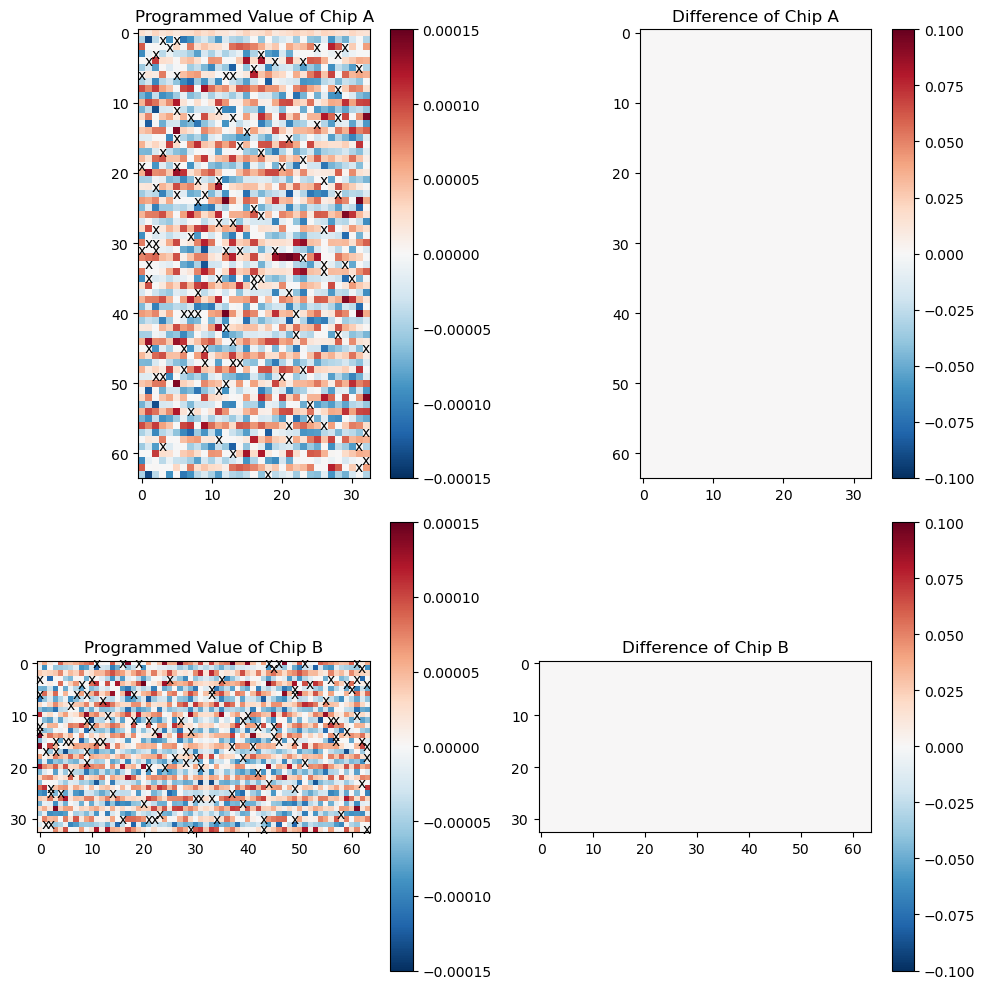

In [8]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
cmap = plt.cm.RdBu_r  # Use RdBu_r colormap: red for positive values, blue for negative values

# Display programmed values of chip A
max_val_A = np.max(np.abs(chipA0.programmed_value.numpy()))
im1 = axes[0, 0].imshow(chipA0.programmed_value.numpy().T, cmap=cmap, vmin=-max_val_A, vmax=max_val_A)
axes[0, 0].set_title('Programmed Value of Chip A')
fig.colorbar(im1, ax=axes[0, 0])

# Mark 'x' at positions where the mask is 0
mask_A = chipA0.mask_matrix.numpy().T
rows_A, cols_A = np.where(mask_A == 0)
for i, j in zip(rows_A, cols_A):
    axes[0, 0].text(j, i, 'x', ha='center', va='center', color='black')

# Display the difference of chip A (programmed value - target value)
diff_A = chipA0.programmed_value - chipA0.target_value
max_diff_A = np.max(np.abs(diff_A.numpy()))
im2 = axes[0, 1].imshow(diff_A.numpy().T, cmap=cmap, vmin=-max_diff_A, vmax=max_diff_A)
axes[0, 1].set_title('Difference of Chip A')
fig.colorbar(im2, ax=axes[0, 1])

# Display programmed values of chip B
max_val_B = np.max(np.abs(chipB0.programmed_value.numpy()))
im3 = axes[1, 0].imshow(chipB0.programmed_value.numpy().T, cmap=cmap, vmin=-max_val_B, vmax=max_val_B)
axes[1, 0].set_title('Programmed Value of Chip B')
fig.colorbar(im3, ax=axes[1, 0])

# Mark 'x' at positions where the mask is 0
mask_B = chipB0.mask_matrix.numpy().T
rows_B, cols_B = np.where(mask_B == 0)
for i, j in zip(rows_B, cols_B):
    axes[1, 0].text(j, i, 'x', ha='center', va='center', color='black')

# Display the difference of chip B (programmed value - target value)
diff_B = chipB0.programmed_value - chipB0.target_value
max_diff_B = np.max(np.abs(diff_B.numpy()))
im4 = axes[1, 1].imshow(diff_B.numpy().T, cmap=cmap, vmin=-max_diff_B, vmax=max_diff_B)
axes[1, 1].set_title('Difference of Chip B')
fig.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# simulation inference

torch.Size([33, 64])


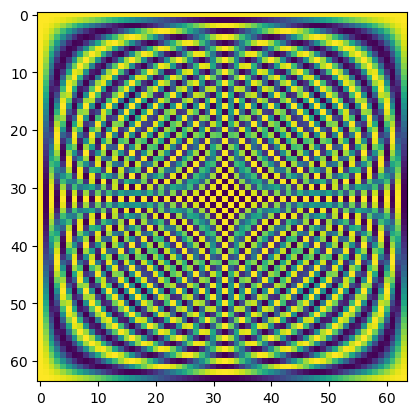

tensor(1.0000, dtype=torch.float64)


In [9]:
temp=chipA0.sim_inference(torch.eye(64).double())
#temp = torch.matmul(chipA.programmed_value, torch.eye(64).double())
print(temp.shape)
#result=chipB.sim_inference(temp)
result = torch.matmul(chipB0.programmed_value, temp)
#result= torch.matmul(Target_A.T,Target_B.T)
plt.imshow(result.cpu().numpy())
plt.show()

cos_result = torch.nn.functional.cosine_similarity(result.flatten(), dft_matrix_real.flatten(), dim=0)
print(cos_result)
